# Few-Shot Adaptation of CLIP with CoCoOp for Fine-Grained Flower Classification
**Deep Learning Project Assignment 2025**<br>
**Team**: Mayora Barcenas Valeria, Tomelleri Jacopo, Tezza Giacomo.

## Abstract
2–3 sentences summarizing purpose and results

## Introduction & Motivation

##### TODO
- Briefly introduce CLIP, few-shot learning, and fine-grained visual recognition.
- Introduce the Oxford Flowers dataset and its challenges (subtle inter-class differences, few labeled examples).
- State the goal: improving CLIP's zero-shot performance via few-shot adaptation with CoCoOp.
- Motivate CoCoOp as the starting method (mention previous results/generalization).
- Define your plan: implement CoCoOp → baseline → extend → evaluate → propose future directions.

## Setup and Baseline
##### TODO
- Environment setup: pip install (all dependencies including clip, torch, tqdm, matplotlib, etc.)
- Set seeds for reproducibility
- Load the Oxford Flowers dataset (reuse template.py's get_data)
    - Show Base/Novel split and explain its purpose (simulate generalization)
- Load CLIP (ViT-B/16) and inspect its architecture (input size, vocab, etc.)
- Perform CLIP zero-shot evaluation:
    - Generate prompts: “a photo of a {flower}, a type of flower”
    - Evaluate and report base, novel, and harmonic mean accuracies.
- Plot: per-class accuracy bar chart, confusion matrix
- Save these metrics for later comparison

### Dependencies and Environment Setup
This section ensures the notebook is reproducible and fully operational across different environments, including Google Colab, AWS SageMaker, and local machines.<br/>
Here it will install all necessary packages, set the working device (CPU/GPU), and configure paths and reproducibility settings.

In [1]:
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])

install("ftfy")
install("regex")
install("tqdm")
install("scikit-learn")
install("scikit-image")
install("pooch")
install("matplotlib")
install("pillow")
install("openai-clip")
install("torch>=2.0")
install("torchvision")

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torchvision

import clip  # OpenAI CLIP

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

2025-07-14 13:25:34.128426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 13:25:34.312513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752499534.337133    1364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752499534.346460    1364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 13:25:34.419124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Using device: cuda


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
# For saving checkpoints, plots, etc.
Path("outputs").mkdir(exist_ok=True)
Path("checkpoints").mkdir(exist_ok=True)
Path("logs").mkdir(exist_ok=True)
Path("data").mkdir(exist_ok=True)

### Dataset Loading and Split
Downloading the data directly from torchvision.

In [5]:
def get_data(data_dir="./data", transform=None):
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    train = torchvision.datasets.Flowers102(root=data_dir, split="train", download=True, transform=transform)
    val = torchvision.datasets.Flowers102(root=data_dir, split="val", download=True, transform=transform)
    test = torchvision.datasets.Flowers102(root=data_dir, split="test", download=True, transform=transform)
    return train, val, test

#### Base and Novel categories
The Oxford Flowers dataset contains 102 classes of flowers. For our experiments, we will split the dataset into base and novel categories. The first 51 classes will be used as base categories, while the remaining 51 classes will be treated as novel categories. This split allows us to simulate a real-world scenario where the model is trained on a set of known categories (base) and evaluated on unseen categories (novel).

In [6]:
def base_novel_categories(dataset):
    # set returns the unique set of all dataset classes
    all_classes = set(dataset._labels)
    # and let's count them
    num_classes = len(all_classes)

    # here list(range(num_classes)) returns a list from 0 to num_classes - 1
    # then we slice the list in half and generate base and novel category lists
    base_classes = list(range(num_classes))[:num_classes//2]
    novel_classes = list(range(num_classes))[num_classes//2:]
    return base_classes, novel_classes

#### Inspect Classes
To inspect the classes, we will first get a dummy test set (without augmentations) as we are just interested in the dataset labels. Then, we will split it using `base_novel_categories`. Finally, we will use the hard-coded `CLASS_NAMES` to print the class names in natural language.

In [7]:
_, _, tmp_test = get_data()
base_classes, novel_classes = base_novel_categories(tmp_test)
CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily", "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia", "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory", "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"]

# Pretty formatted print of base and novel classes
def print_classes(label, classes, class_names):
    print(f"{label} Classes:")
    for i in classes:
        print(f"{i:3d}: {class_names[i]}")
    print()

print_classes("Base", base_classes, CLASS_NAMES)
print_classes("Novel", novel_classes, CLASS_NAMES)

Base Classes:
  0: pink primrose
  1: hard-leaved pocket orchid
  2: canterbury bells
  3: sweet pea
  4: english marigold
  5: tiger lily
  6: moon orchid
  7: bird of paradise
  8: monkshood
  9: globe thistle
 10: snapdragon
 11: colt's foot
 12: king protea
 13: spear thistle
 14: yellow iris
 15: globe-flower
 16: purple coneflower
 17: peruvian lily
 18: balloon flower
 19: giant white arum lily
 20: fire lily
 21: pincushion flower
 22: fritillary
 23: red ginger
 24: grape hyacinth
 25: corn poppy
 26: prince of wales feathers
 27: stemless gentian
 28: artichoke
 29: sweet william
 30: carnation
 31: garden phlox
 32: love in the mist
 33: mexican aster
 34: alpine sea holly
 35: ruby-lipped cattleya
 36: cape flower
 37: great masterwort
 38: siam tulip
 39: lenten rose
 40: barbeton daisy
 41: daffodil
 42: sword lily
 43: poinsettia
 44: bolero deep blue
 45: wallflower
 46: marigold
 47: buttercup
 48: oxeye daisy
 49: common dandelion
 50: petunia

Novel Classes:
 51: wil

#### Split Dataset
The next step is to actually split the dataset into the base and novel categories we extract from `base_novel_categories`.
To split the data we need the dataset and the list of base classes. If the sample label is not part of the base categories, then it must be part of the novel ones.

In [8]:
def split_data(dataset, base_classes):
    # these two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # we create a set of base classes to compute the test below in O(1)
    # this is optional and can be removed
    base_set = set(base_classes)

    # here we iterate over sample labels and also get the correspondent sample index
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # here we create the dataset subsets
    # the torch Subset is just a wrapper around the dataset
    # it simply stores the subset indexes and the original dataset (your_subset.dataset)
    # when asking for sample i in the subset, torch will look for its original position in the dataset and retrieve it
    # https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset

#### Extract k shots
As the dataset already provides 10 train and validation shots, we do not need to extract them.
Beaware that Few-Shot Adaptation papers must do this operation as most datasets count significantly more samples in both the training and validation sets.

### CLIP (ViT-B/16) Loading and Inspection

In [9]:
# available models = ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
model, preprocess = clip.load("ViT-B/16", device=device)

# preprocess contains CLIP's pre-defined augmentations, let's inspect them!
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa8eafa5440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

#### Load and Prepare Data
Here we get the three dataset split and pass clip pre-defined augmentations.
Then, we compute base and novel categories (in this case is redundand as we already did it before).
Finally, we split the three datasets into base and novel categories.
As we want to use the novel categories only for the test set, we drop `train_novel` and `val_novel`.

In [10]:
# get the three datasets
train_set, val_set, test_set = get_data(transform=preprocess)

# split classes into base and novel
base_classes, novel_classes = base_novel_categories(train_set)

# split the three datasets
train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)

### Compute Zero-Shot Predictions

In [11]:
@torch.no_grad() # we don't want gradients
def eval(model, dataset, categories, batch_size, device, label=""):
    # let's set the model in evaluation mode
    model.eval()

    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    # here we apply the standard CLIP template used for oxford flowers to all categories
    # and immediately tokenize each sentence (convert natural language into numbers - feel free to print the text input to inspect them)
    text_inputs = clip.tokenize(
        [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    ).to(device)

    # we can encode the text features once as they are shared for all images
    # therefore we do it outside the evaluation loop
    text_features = model.encode_text(text_inputs)
    # and here we normalize them (standard pratice with CLIP)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # simple dataloader creation
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # here we store the number of correct predictions we will make
    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        # base categories range from 0 to 50, while novel ones from 51 to 101
        # therefore we must map categories to the [0, 50], otherwise we will have wrong predictions
        # Map targets in contiguous set starting from zero
        # Labels needs to be .long() in pytorch
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()

        image = image.to(device)
        target = target.to(device)

        # forward image through CLIP image encoder
        image_features = model.encode_image(image)
        # and normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # here cosine similarity between image and text features and keep the argmax for every row (every image)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        # now we check which are correct, and sum them (False == 0, True == 1)
        correct_predictions += (predicted_class == target).sum().item()

    # and now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy

In [12]:
base_accuracy = eval(model=model, dataset=test_base, categories=base_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Base Classes")
novel_accuracy = eval(model=model, dataset=test_novel, categories=novel_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Novel Classes")

print()
print(f"🔍 Base classes accuracy: {base_accuracy*100:.2f}%")
print(f"🔍 Novel classes accuracy: {novel_accuracy*100:.2f}%")

🧠 Zero-shot evaluation on Novel Classes: 100%|██████████| 29/29 [00:18<00:00,  1.59it/s]


🔍 Base classes accuracy: 71.33%
🔍 Novel classes accuracy: 78.24%


#### Harmonic Mean
Few-Shot Adaptations papers usually report the Harmonic Mean.
The harmonic mean tends to mitigate the impact of large outliers (base accuracy) and aggravate the impact of small ones (novel accuracy).
Thus, achieving very high base accuracies at the expense of the novel accuracy will be penalized by the HM.

In [13]:
def harmonic_mean(base_accuracy, novel_accuracy):
    numerator = 2
    denominator = 1 / base_accuracy + 1 / novel_accuracy
    hm = numerator / denominator
    return hm

# print(f"🔍 Harmonic Mean: {harmonic_mean(base_accuracy, novel_accuracy)*100:.2f}%")

### Baseline evaluation and Plots

## Methodology: CoCoOp
##### TODO
- Provide a short literature summary of CoCoOp with diagram (can be ASCII or markdown)
    - What it is (image-conditioned prompt learning)
    - Why it helps (avoids overfitting class tokens, learns better generalization)
- Describe the architecture:
    - MetaNet / PromptLearner: learn image-conditioned soft prompts
    - Prompt format: [CLS] + ctx_tokens + class name + EOS
    - Only prompt tokens and MetaNet are updated, CLIP remains frozen
- Present equations:
    - Prompt generation
    - Similarity computation
    - Cross-entropy loss over cosine similarity
- Show a schematic of the training pipeline (optional visual diagram)

## Implementation: CoCoOp Baseline
In this section, we implement the CoCoOp (Conditional Context Optimization) method for adapting CLIP to our downstream task. CoCoOp extends the original CoOp approach by generating prompts that are conditioned on the input image. The only trainable components are:

- A PromptLearner module that generates learnable context tokens
- A small MetaNet (image-conditional MLP) that produces dynamic prompt embeddings

We freeze CLIP's visual and text encoders and only train the prompt learner to minimize cross-entropy over the Base training set.

##### TODO
- Create PromptLearner module (copy from lab.py and adapt for Oxford Flowers)
- Load CLIP
- Freeze CLIP weights
- Setup train/val/test splits from base classes only
- Train PromptLearner on base classes
- Use tokenizer and pre-tokenized text prompts for classnames
- Implement optimizer, scheduler, and loss function
- Report model summary (trainable params)
- Show training logs: loss and accuracy curves

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from torch.utils.data import DataLoader


_tokenizer = _Tokenizer()

In [15]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts.to(self.dtype) + self.positional_embedding.to(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)]
        return x @ self.text_projection

In [16]:
class PromptLearner(nn.Module):
    def __init__(self, class_ids, class_names, clip_model, n_ctx=4, ctx_init=None, device="cuda"):
        super().__init__()
        self.dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        vis_dim = clip_model.visual.output_dim
        self.device = device
        self.n_cls = len(class_ids)
        self.n_ctx = n_ctx

        self.class_ids = class_ids
        self.classnames = [class_names[c].replace("_", " ") for c in class_ids]

        if ctx_init:
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            # prompt = clip.tokenize(ctx_init).to(clip_model.token_embedding.weight.device)
            prompt = clip.tokenize(ctx_init).to(device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).to(self.dtype)
            ctx_vectors = embedding[0, 1:1+n_ctx, :]
            prompt_prefix = ctx_init
        else:
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=torch.float32)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f'Initial context: "{prompt_prefix}"')
        print(f"# of context tokens: {n_ctx}")

        self.ctx = nn.Parameter(ctx_vectors)

        self.meta_net = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(vis_dim, vis_dim // 16)),
            ("relu", nn.ReLU(inplace=True)),
            ("linear2", nn.Linear(vis_dim // 16, ctx_dim))
        ])).to(device)

        prompts = [prompt_prefix + " " + name + "." for name in self.classnames]
        # tokenized = torch.cat([clip.tokenize(p) for p in prompts]).to(clip_model.token_embedding.weight.device)
        tokenized = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized).to(self.dtype)

        self.register_buffer("token_prefix", embedding[:, :1, :]) #SOS
        self.register_buffer("token_suffix", embedding[:, 1+n_ctx:, :]) #CLS, EOS
        self.tokenized_prompts = tokenized

    def construct_prompts(self, ctx, prefix, suffix, label=None):
        if label is not None:
            prefix = prefix[label]
            suffix = suffix[label]
        return torch.cat([prefix, ctx, suffix], dim=1)

    def forward(self, image_features):
        B = image_features.shape[0]
        ctx = self.ctx.to(self.dtype).unsqueeze(0)                # (1, n_ctx, dim)
        bias = self.meta_net(image_features.float()).unsqueeze(1)  # (B, 1, dim)
        ctx_shifted = ctx + bias                   # (B, n_ctx, dim)

        prefix = self.token_prefix
        suffix = self.token_suffix

        prompts = []
        for ctx_i in ctx_shifted:
            ctx_exp = ctx_i.unsqueeze(0).expand(self.n_cls, -1, -1)       # (n_cls, n_ctx, dim)
            pts = self.construct_prompts(ctx_exp, prefix, suffix)         # (n_cls, ?, dim)
            prompts.append(pts)
        return torch.stack(prompts)  # (B, n_cls, ?, dim)


In [17]:
class CoCoOp(nn.Module):
    def __init__(self, class_ids, class_names, clip_model, n_ctx=4, ctx_init=None, device="cuda"):
        super().__init__()
        self.device = device
        self.prompt_learner = PromptLearner(class_ids, class_names, clip_model, n_ctx=n_ctx, ctx_init=ctx_init, device=device).to(device)
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model).to(device)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype
        self.class_ids = class_ids

        # Freeze everything except prompt learner
        for name, param in self.named_parameters():
            if "prompt_learner" not in name:
                param.requires_grad_(False)

        print(f"Totla parameters: {sum(p.numel() for p in self.parameters())}")
        print(f"Trainable parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad)}")

    # For compatibility with the original CLIP interface
    def encode_text(self, text_inputs):
        ctx = self.prompt_learner.ctx # (n_ctx, dim)
        prefix = self.prompt_learner.token_prefix # (n_cls, 1, dim)
        suffix = self.prompt_learner.token_suffix # (n_cls, ?, dim)
        # Build prompts using learned ctx (no conditioning)
        ctx = ctx.unsqueeze(0).expand(self.prompt_learner.n_cls, -1, -1)  # (n_cls, n_ctx, dim)
        prompts = torch.cat([prefix, ctx, suffix], dim=1)  # (n_cls, prompt_len, dim)
        
        return self.text_encoder(prompts, self.prompt_learner.tokenized_prompts)

    # For compatibility with the original CLIP interface
    def encode_image(self, image):
        image_features = self.image_encoder(image.to(dtype=self.dtype))
        return image_features / image_features.norm(dim=-1, keepdim=True)

    def forward(self, images, labels=None):
        images = images.to(self.device).to(self.dtype)
        image_features = self.image_encoder(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        prompts = self.prompt_learner(image_features)

        logits = []
        for p_i, i_f in zip(prompts, image_features):
            text_features = self.text_encoder(p_i, self.tokenized_prompts)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            logit = self.logit_scale.exp() * i_f @ text_features.T
            logits.append(logit)
        logits = torch.stack(logits)

        if self.training and labels is not None:
            return F.cross_entropy(logits, labels)

        return logits

We now define the training and evaluation logic for CoCoOp using the Base training classes only. The model is trained to optimize cross-entropy loss over class predictions.

In [18]:
def training_step(net, data_loader, optimizer, cost_function, device="cuda", desc="Training"):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  net.train()

  pbar = tqdm(data_loader, desc=desc, position=0, leave=True, total=len(data_loader))
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = cost_function(outputs, targets)
    loss.backward()
    optimizer.step()

    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1)

    cumulative_accuracy += (predicted == targets).sum().item()

    pbar.set_postfix(train_loss=loss.item(), train_acc=cumulative_accuracy / samples * 100)
    pbar.update(1)
    torch.cuda.empty_cache()

  return cumulative_loss / samples, cumulative_accuracy /samples * 100


def test_step(net, data_loader, cost_function, device="cuda", desc="Testing", categories=None):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  net.eval()

  # If categories are provided, build mapping for contiguous labels
  if categories is not None:
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}

  pbar = tqdm(data_loader, desc=desc, position=0, leave=True, total=len(data_loader))
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Remap targets if categories are provided
      if categories is not None:
        targets = torch.Tensor([contig_cat2idx[t.item()] for t in targets]).long().to(device)

      outputs = net(inputs)
      loss = cost_function(outputs, targets)
      samples += inputs.shape[0]
      cumulative_loss += loss.item()
      _, predicted = outputs.max(dim=1)

      cumulative_accuracy += (predicted == targets).sum().item()

      pbar.set_postfix(test_loss=loss.item(), test_acc=cumulative_accuracy / samples * 100)
      pbar.update(1)

  return cumulative_loss / samples, cumulative_accuracy / samples * 100

In [19]:
def get_optimizer(model, lr, wd, momentum):
  optimizer = torch.optim.SGD(
      [{"params": model.parameters()}],
      lr=lr,
      momentum=momentum,
      weight_decay=wd,
      nesterov=True,
  )
  return optimizer

def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

In [20]:
%load_ext tensorboard
%tensorboard --logdir=runs

Training on 51 classes
Initial context: "X X X X"
# of context tokens: 4
Totla parameters: 124359201
Trainable parameters: 35360


Valid Epoch 15/15: 100%|██████████| 510/510 [00:19<00:00, 26.17it/s, test_acc=92.2, test_loss=0.0237]  


Early stopping at epoch 15 (no improvement for 5 epochs)
Best Val Accuracy: 93.92% at epoch 10


Final Novel Evaluation: 100%|██████████| 3676/3676 [02:19<00:00, 26.34it/s, test_acc=2.99, test_loss=17.2]    


After Training:
Train Loss: 0.12766		Train Accuracy: 98.23529
Valid Loss: 0.27638		Valid Accuracy: 92.15686
Base Loss: 0.27019		Base Accuracy: 92.03397
Novel Loss: 9.85161		Novel Accuracy: 2.99238

Results:
🔍 Base classes accuracy: 9203.40%
🔍 Novel classes accuracy: 299.24%
🔍 Harmonic Mean: 579.63%


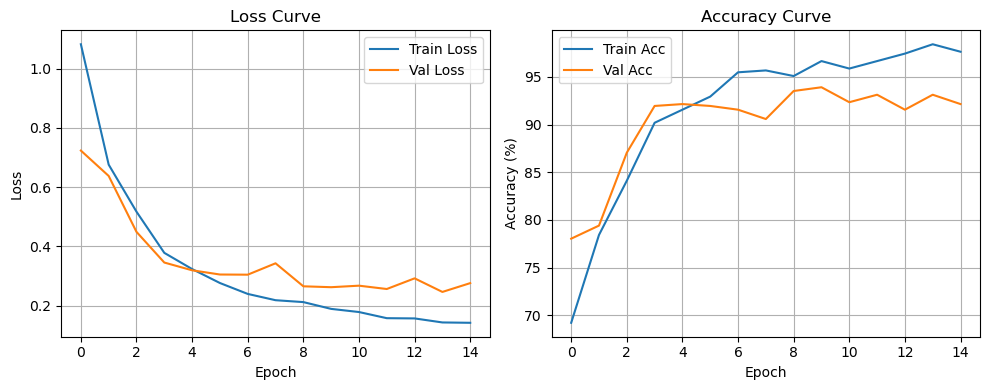

In [ ]:
def main_cocoop(
    batch_size=1,
    device="cuda:0",
    learning_rate=0.002,
    weight_decay=0.0005,
    momentum=0.9,
    epochs=15,
    run_name="exp_1.2",
    n_ctx=4,
    ctx_init=None,
):
    writer = SummaryWriter(f"runs/{run_name}")

    clip_model, preprocess = clip.load("ViT-B/16", device=device)
    train_set, val_set, test_set = get_data(transform=preprocess)
    base_classes, novel_classes = base_novel_categories(train_set)
    train_base, _ = split_data(train_set, base_classes)
    val_base, _ = split_data(val_set, base_classes)
    test_base, test_novel = split_data(test_set, base_classes)

    print(f"Training on {len(base_classes)} classes")

    train_loader = DataLoader(train_base, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_base, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader_base = DataLoader(test_base, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader_novel = DataLoader(test_novel, batch_size=batch_size, shuffle=False, num_workers=2)

    model = CoCoOp(base_classes, CLASS_NAMES, clip_model, n_ctx=n_ctx, ctx_init=ctx_init, device=device)
    optimizer = get_optimizer(model, learning_rate, weight_decay, momentum)
    cost_function = get_cost_function()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Log hyperparameters
    writer.add_hparams(
        {
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "momentum": momentum,
            "epochs": epochs,
            "n_ctx": n_ctx,
        }, {}
    )

    best_val_acc = 0.0
    best_epoch = -1
    checkpoint_path = f"checkpoints/{run_name}_best.pt"
    last_checkpoint_path = f"checkpoints/{run_name}_last.pt"
    early_stop_patience = 5
    patience_counter = 0

    try:
        for e in range(epochs):
            train_loss, train_acc = training_step(model, train_loader, optimizer, cost_function, device=device, desc=f"Train Epoch {e+1}/{epochs}")
            val_loss, val_acc = test_step(model, val_loader, cost_function, device=device, desc=f"Valid Epoch {e+1}/{epochs}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            writer.add_scalars("Loss", {"Train": train_loss, "Val": val_loss}, e)
            writer.add_scalars("Accuracy", {"Train": train_acc, "Val": val_acc}, e)
            writer.flush()

            # Checkpoint: Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = e
                patience_counter = 0
                torch.save({
                    'epoch': e,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'train_acc': train_acc,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, checkpoint_path)
            else:
                patience_counter += 1

            # Save last checkpoint every epoch
            torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, last_checkpoint_path)

            # Early stopping
            if patience_counter >= early_stop_patience:
                print(f"Early stopping at epoch {e+1} (no improvement for {early_stop_patience} epochs)")
                break

    except KeyboardInterrupt:
        print("Training interrupted. Saving last checkpoint...")
        torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, last_checkpoint_path)

    print(f"Best Val Accuracy: {best_val_acc:.2f}% at epoch {best_epoch+1}")
    # prof_eval_base_acc = eval(model, test_base, base_classes, 128, device, label="Test Zero Shot on Base")
    # prof_eval_novel_acc = eval(model, test_novel, novel_classes, 128, device, label="Test Zero Shot on Novel")

    train_loss, train_acc = test_step(model, train_loader, cost_function, device=device, desc="Final Train Evaluation")
    val_loss, val_acc = test_step(model, val_loader, cost_function, device=device, desc="Final Valid Evaluation")
    eval_base_loss, eval_base_acc = test_step(model, test_loader_base, cost_function, device=device, desc="Final Base Evaluation", categories=base_classes)
    eval_novel_loss, eval_novel_acc = test_step(model, test_loader_novel, cost_function, device=device, desc="Final Novel Evaluation", categories=novel_classes)
    hm = harmonic_mean(eval_base_acc, eval_novel_acc)

    # Log final metrics
    writer.add_scalar("Test/Base Accuracy", eval_base_acc)
    writer.add_scalar("Test/Novel Accuracy", eval_novel_acc)
    writer.add_scalar("Test/Harmonic Mean", hm)
    writer.flush()

    print("After Training:")
    print(f"Train Loss: {train_loss:.5f}\t\tTrain Accuracy: {train_acc:.5f}")
    print(f"Valid Loss: {val_loss:.5f}\t\tValid Accuracy: {val_acc:.5f}")
    print(f"Base Loss: {eval_base_loss:.5f}\t\tBase Accuracy: {eval_base_acc:.5f}")
    print(f"Novel Loss: {eval_novel_loss:.5f}\t\tNovel Accuracy: {eval_novel_acc:.5f}")

    print("\nResults:")
    print(f"🔍 Base classes accuracy: {eval_base_acc*100:.2f}%")
    print(f"🔍 Novel classes accuracy: {eval_novel_acc*100:.2f}%")
    print(f"🔍 Harmonic Mean: {hm*100:.2f}%")

    # Plot accuracy and loss curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(range(epochs), train_accs, label="Train Acc")
    plt.plot(range(epochs), val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"outputs/{run_name}_curves.png")
    plt.show()

    # Log charts to TensorBoard
    writer.add_figure("Curves", plt.gcf())
    writer.close()

main_cocoop()

## Evaluation: CoCoOp Baseline
##### TODO
- Evaluate CoCoOp on:
    - Base test set (base classes)
    - Novel test set (novel classes) — zero-shot generalization
- Compute Harmonic Mean
- Compare with baseline CLIP (from Section 2)
- Show:
    - Table with Base, Novel, HM for both CLIP and CoCoOp
    - Confusion matrices
    - Accuracy per class (bar plots)
    - Line plot of train/val curves
- Discuss: Where does CoCoOp help most? Are any flowers still confused?

## Extensions

## Conclusion & Takeaways
##### TODO
- Summarize performance gains vs. zero-shot
- Highlight where CoCoOp shines and its limitations
- Discuss extensibility and future work
- Reflect on challenges in fine-grained adaptation

## References
##### TODO
- Radford et al., 2021 (CLIP)
- Zhou et al., 2022 (CoOp/CoCoOp)
- Additional relevant few-shot learning work (e.g., Tip-Adapter, VPT, etc.)

## Appendix